In [1]:
# load packages
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm 
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn.functional as F
from torch.utils import data
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.33)
# N, D = X_train.shape

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
def prepare_x(data):
    df1 = data[:40, :].T
    return np.array(df1)

def get_label(data):
    lob = data[-5:, :].T
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)

    dY = np.array(Y)

    dataY = dY[T - 1:N]

    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]

    return dataX, dataY

def torch_data(x, y):
    x = torch.from_numpy(x)
    x = torch.unsqueeze(x, 1)
    y = torch.from_numpy(y)
    y = F.one_hot(y, num_classes=3)
    return x, y

In [4]:
class Dataset(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, data, k, num_classes, T):
        """Initialization""" 
        self.k = k
        self.num_classes = num_classes
        self.T = T
            
        x = prepare_x(data)
        y = get_label(data)
        x, y = data_classification(x, y, self.T)
        y = y[:,self.k] - 1
        self.length = len(x)

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.y = torch.from_numpy(y)

    def __len__(self):
        """Denotes the total number of samples"""
        return self.length

    def __getitem__(self, index):
        """Generates samples of data"""
        return self.x[index], self.y[index]

In [5]:
# please change the data_path to your local path
# data_path = '/nfs/home/zihaoz/limit_order_book/data'

dec_data = np.loadtxt('LOB_data/Train_Dst_NoAuction_DecPre_CF_7.txt')
# dec_train = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.8))]
# dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]

dec_test1 = np.loadtxt('LOB_data/Test_Dst_NoAuction_DecPre_CF_7.txt')
dec_test2 = np.loadtxt('LOB_data/Test_Dst_NoAuction_DecPre_CF_8.txt')
dec_test3 = np.loadtxt('LOB_data/Test_Dst_NoAuction_DecPre_CF_9.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

dec_train_full = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.8))]
dec_val_full = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]

# Reduce the size of training and validation data to a quarter
dec_train = dec_train_full[:, :int(np.floor(dec_train_full.shape[1] * 0.75))]
dec_val = dec_val_full[:, :int(np.floor(dec_val_full.shape[1] * 0.75))]

# Combine test datasets and reduce to a quarter
dec_test_full = np.hstack((dec_test1, dec_test2, dec_test3))
dec_test = dec_test_full[:, :int(np.floor(dec_test_full.shape[1] * 0.75))]

print(dec_train.shape, dec_val.shape, dec_test.shape)

(149, 152850) (149, 38212) (149, 104690)


In [6]:
batch_size = 256

dataset_train = Dataset(data=dec_train, k=4, num_classes=3, T=100)
dataset_val = Dataset(data=dec_val, k=4, num_classes=3, T=100)
dataset_test = Dataset(data=dec_test, k=4, num_classes=3, T=100)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

print(dataset_train.x.shape, dataset_train.y.shape)

torch.Size([152751, 1, 100, 40]) torch.Size([152751])


In [7]:
tmp_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=1, shuffle=True)

for x, y in tmp_loader:
    print(x)
    print(y)
    print(x.shape, y.shape)
    break

tensor([[[[2.6490e-01, 4.3300e-03, 2.6470e-01,  ..., 5.0000e-03,
           2.6230e-01, 1.8000e-03],
          [2.6500e-01, 1.5600e-03, 2.6480e-01,  ..., 2.0820e-02,
           2.6220e-01, 3.3170e-02],
          [2.6520e-01, 5.0000e-05, 2.6480e-01,  ..., 1.4600e-02,
           2.6200e-01, 1.1000e-02],
          ...,
          [2.6470e-01, 4.9500e-03, 2.6420e-01,  ..., 9.3000e-04,
           2.6120e-01, 1.1000e-02],
          [2.6470e-01, 2.9500e-03, 2.6420e-01,  ..., 9.3000e-04,
           2.6200e-01, 1.1000e-02],
          [2.6470e-01, 2.4100e-03, 2.6420e-01,  ..., 7.8000e-04,
           2.6200e-01, 1.1000e-02]]]], dtype=torch.float64)
tensor([2.], dtype=torch.float64)
torch.Size([1, 1, 100, 40]) torch.Size([1])


In [9]:
class deeplob(nn.Module):
    def __init__(self, y_len):
        super().__init__()
        self.y_len = y_len
        
        # convolution blocks
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.LeakyReLU(negative_slope=0.01),
#             nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,10)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        
        # inception moduels
        self.inp1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp3 = nn.Sequential(
            nn.MaxPool2d((3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        
        # lstm layers
        self.lstm = nn.LSTM(input_size=192, hidden_size=64, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(64, self.y_len)

    def forward(self, x):
        # h0: (number of hidden layers, batch size, hidden size)
        h0 = torch.zeros(1, x.size(0), 64).to(device)
        c0 = torch.zeros(1, x.size(0), 64).to(device)
    
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x_inp1 = self.inp1(x)
        x_inp2 = self.inp2(x)
        x_inp3 = self.inp3(x)  
        
        x = torch.cat((x_inp1, x_inp2, x_inp3), dim=1)
        
#         x = torch.transpose(x, 1, 2)
        x = x.permute(0, 2, 1, 3)
        x = torch.reshape(x, (-1, x.shape[1], x.shape[2]))
        
        x, _ = self.lstm(x, (h0, c0))
        x = x[:, -1, :]
        x = self.fc1(x)
        forecast_y = torch.softmax(x, dim=1)
        
        return forecast_y

In [10]:
model = deeplob(y_len = dataset_train.num_classes)
model.to(device)

deeplob(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): Tanh()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): Tanh()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(4, 1), stride

In [11]:
summary(model, (1, 1, 100, 40))

Layer (type:depth-idx)                   Output Shape              Param #
deeplob                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 32, 94, 20]           --
│    └─Conv2d: 2-1                       [1, 32, 100, 20]          96
│    └─LeakyReLU: 2-2                    [1, 32, 100, 20]          --
│    └─BatchNorm2d: 2-3                  [1, 32, 100, 20]          64
│    └─Conv2d: 2-4                       [1, 32, 97, 20]           4,128
│    └─LeakyReLU: 2-5                    [1, 32, 97, 20]           --
│    └─BatchNorm2d: 2-6                  [1, 32, 97, 20]           64
│    └─Conv2d: 2-7                       [1, 32, 94, 20]           4,128
│    └─LeakyReLU: 2-8                    [1, 32, 94, 20]           --
│    └─BatchNorm2d: 2-9                  [1, 32, 94, 20]           64
├─Sequential: 1-2                        [1, 32, 88, 10]           --
│    └─Conv2d: 2-10                      [1, 32, 94, 10]           2,080
│    └

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [14]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    best_test_loss = np.inf
    best_test_epoch = 0

    for it in tqdm(range(epochs)):
        
        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # move data to GPU
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)
            # print("inputs.shape:", inputs.shape)
            # zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            # print("about to get model output")
            outputs = model(inputs)
            # print("done getting model output")
            # print("outputs.shape:", outputs.shape, "targets.shape:", targets.shape)
            loss = criterion(outputs, targets)
            # Backward and optimize
            # print("about to optimize")
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading
    
        model.eval()
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)      
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        if test_loss < best_test_loss:
            torch.save(model, './best_val_model_pytorch2')
            best_test_loss = test_loss
            best_test_epoch = it
            print('model saved')

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Validation Loss: {test_loss:.4f}, Duration: {dt}, Best Val Epoch: {best_test_epoch}')

    return train_losses, test_losses

In [15]:
train_losses, val_losses = batch_gd(model, criterion, optimizer, 
                                    train_loader, val_loader, epochs=6)

 17%|██████▊                                  | 1/6 [30:18<2:31:31, 1818.35s/it]

model saved
Epoch 1/6, Train Loss: 0.9630,           Validation Loss: 1.1679, Duration: 0:30:18.338356, Best Val Epoch: 0


 33%|█████████████                          | 2/6 [1:01:22<2:03:01, 1845.46s/it]

Epoch 2/6, Train Loss: 0.8454,           Validation Loss: 1.1736, Duration: 0:31:04.380492, Best Val Epoch: 0


 50%|███████████████████▌                   | 3/6 [1:32:35<1:32:53, 1857.87s/it]

Epoch 3/6, Train Loss: 0.8057,           Validation Loss: 1.1743, Duration: 0:31:12.575608, Best Val Epoch: 0


 67%|██████████████████████████             | 4/6 [2:03:33<1:01:55, 1857.80s/it]

Epoch 4/6, Train Loss: 0.7858,           Validation Loss: 1.1746, Duration: 0:30:57.624312, Best Val Epoch: 0


 83%|██████████████████████████████████▏      | 5/6 [2:34:03<30:47, 1847.95s/it]

Epoch 5/6, Train Loss: 0.7713,           Validation Loss: 1.1747, Duration: 0:30:30.422001, Best Val Epoch: 0


100%|█████████████████████████████████████████| 6/6 [3:04:28<00:00, 1844.69s/it]

Epoch 6/6, Train Loss: 0.7611,           Validation Loss: 1.1748, Duration: 0:30:24.462972, Best Val Epoch: 0


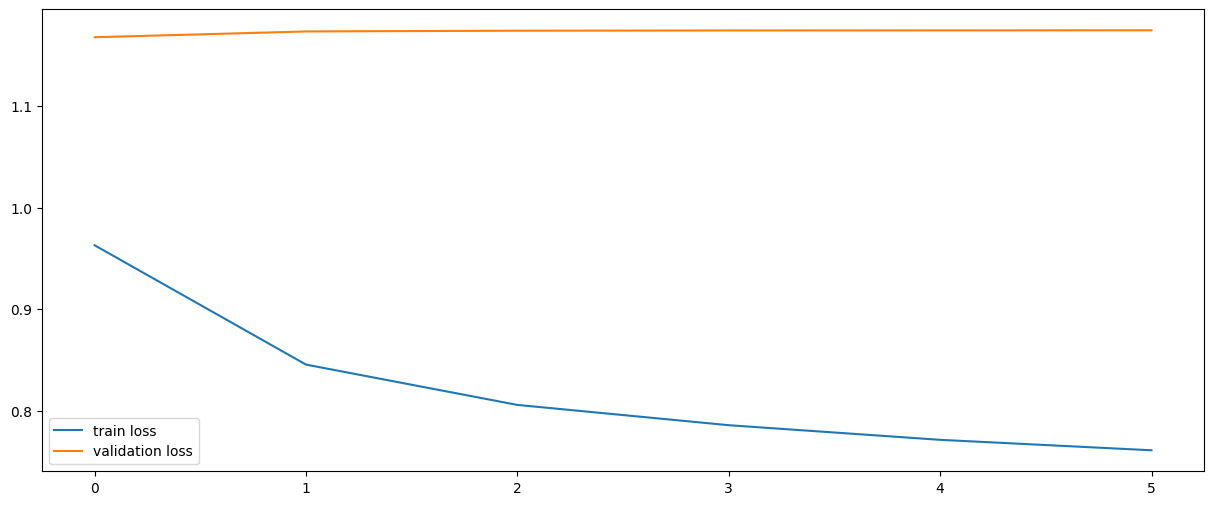

In [16]:
plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

In [17]:
model = torch.load('best_val_model_pytorch2')

n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")

Test acc: 0.5327


In [18]:
# model = torch.load('best_val_model_pytorch')
all_targets = []
all_predictions = []

for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions)    

In [19]:
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

accuracy_score: 0.5327322618580949
              precision    recall  f1-score   support

           0     0.6587    0.4114    0.5065     34898
           1     0.7577    0.4641    0.5756     37832
           2     0.3993    0.7472    0.5204     31861

    accuracy                         0.5327    104591
   macro avg     0.6052    0.5409    0.5342    104591
weighted avg     0.6155    0.5327    0.5357    104591

